In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=da02446c39affaf18fe0c1d10a24c549720793d825e3d346713bb7b3cb4fcd7e
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=a9bdc0f56370e5519d0ae8d3e15ee59a957f22a4356d8e0d2d84ed23fa13090d
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 1. Tổng quan và phân tích dữ liệu

In [ ]:
data_path = '/content/drive/MyDrive/Nhận dạng/Bài tập trên lớp/Homework_1/real_estate_dataset.csv'

In [ ]:
df = pd.read_csv(data_path)
df

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1.0,3.0,3.0,1967.0,1.0,1.0,48.0,8.297631,5.935734,602134.8167
1,2,287.678577,1.0,2.0,1.0,1949.0,0.0,1.0,37.0,6.061466,10.827392,591425.1354
2,3,NaN,1.0,3.0,2.0,1923.0,1.0,NaN,NaN,NaN,6.904599,464478.6969
3,4,199.664621,5.0,2.0,2.0,1918.0,0.0,0.0,17.0,2.070949,8.284019,583105.6560
4,5,89.004660,4.0,3.0,3.0,1999.0,1.0,0.0,34.0,1.523278,14.648277,619879.1425
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,138.338057,2.0,2.0,2.0,1967.0,1.0,0.0,16.0,4.296086,5.562583,488496.3507
496,497,195.914028,2.0,3.0,1.0,1977.0,0.0,1.0,45.0,7.406261,2.845105,657736.9217
497,498,69.433659,1.0,1.0,2.0,2004.0,0.0,0.0,18.0,8.629724,6.263264,405324.9502
498,499,293.598702,5.0,1.0,3.0,1940.0,1.0,0.0,41.0,5.318891,16.990684,773035.9680


In [ ]:
df.shape

(500, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         486 non-null    float64
 2   Num_Bedrooms        466 non-null    float64
 3   Num_Bathrooms       466 non-null    float64
 4   Num_Floors          475 non-null    float64
 5   Year_Built          474 non-null    float64
 6   Has_Garden          478 non-null    float64
 7   Has_Pool            477 non-null    float64
 8   Garage_Size         463 non-null    float64
 9   Location_Score      472 non-null    float64
 10  Distance_to_Center  396 non-null    float64
 11  Price               482 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 47.0 KB


In [ ]:
cols = df.columns.tolist()
cols

['ID',
 'Square_Feet',
 'Num_Bedrooms',
 'Num_Bathrooms',
 'Num_Floors',
 'Year_Built',
 'Has_Garden',
 'Has_Pool',
 'Garage_Size',
 'Location_Score',
 'Distance_to_Center',
 'Price']

                    Missing Values  Percentage (%)
Square_Feet                     14             2.8
Num_Bedrooms                    34             6.8
Num_Bathrooms                   34             6.8
Num_Floors                      25             5.0
Year_Built                      26             5.2
Has_Garden                      22             4.4
Has_Pool                        23             4.6
Garage_Size                     37             7.4
Location_Score                  28             5.6
Distance_to_Center             104            20.8
Price                           18             3.6


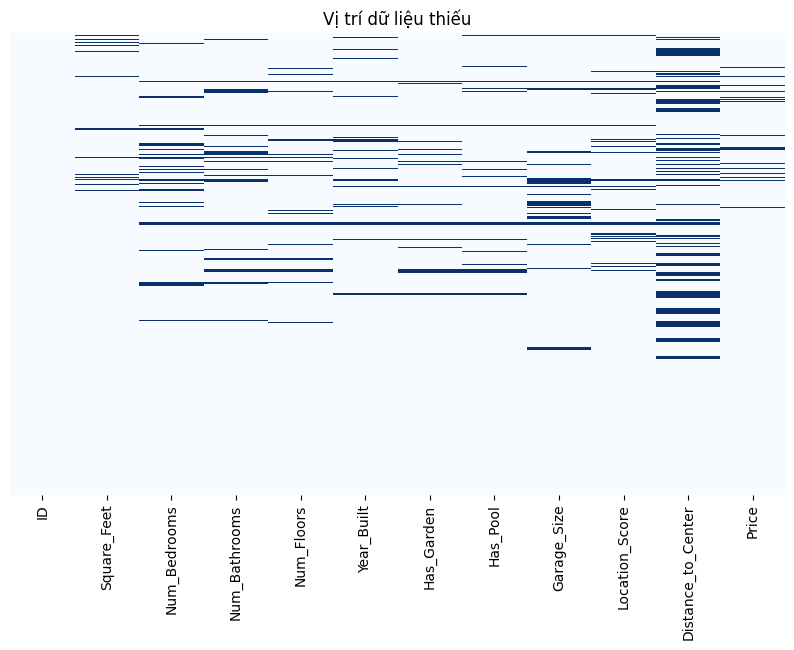

In [ ]:
missing_values = df[cols].isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
missing_df = missing_df[missing_df['Missing Values'] > 0]
print(missing_df)

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='Blues', cbar=False, yticklabels=False)
plt.title("Vị trí dữ liệu thiếu")
plt.show()

In [ ]:
# các cột rời rạc
cat_cols = ['Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built','Has_Garden', 'Has_Pool']
df[cat_cols] = df[cat_cols].astype('category')

# các cột liên tục
num_cols = ['Square_Feet', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']

In [ ]:
df[cat_cols].describe()

,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool
count,466.0,466.0,475.0,474.0,478.0,477.0
unique,5.0,3.0,3.0,120.0,2.0,2.0
top,1.0,1.0,2.0,1920.0,1.0,0.0
freq,104.0,162.0,172.0,12.0,262.0,243.0


<ipython-input-20-b19aab8db492>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Blues", order=df[col].value_counts().index)
<ipython-input-20-b19aab8db492>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Blues", order=df[col].value_counts().index)
<ipython-input-20-b19aab8db492>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Blues", order=df[col].value_counts().index)
<ipython-input-20-b19aab8db492>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecate

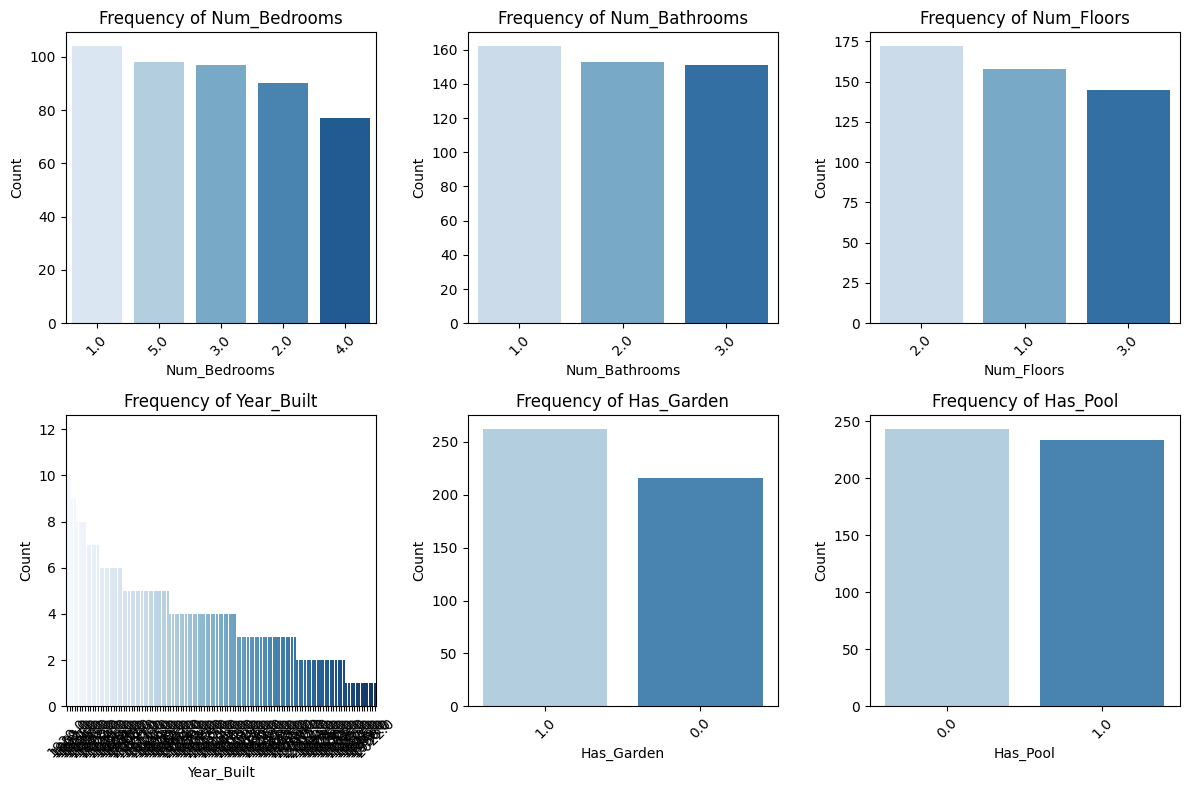

In [ ]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(cat_cols):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=df[col], palette="Blues", order=df[col].value_counts().index)
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df[num_cols].describe()

,Square_Feet,Garage_Size,Location_Score,Distance_to_Center,Price
count,486.000000,463.000000,472.000000,396.000000,482.000000
mean,174.378454,30.185745,5.198274,10.451424,582905.171008
std,74.735332,11.645933,2.866391,5.601969,123378.609003
min,51.265396,10.000000,0.004428,0.062818,276892.470100
25%,110.475759,20.000000,2.760650,5.904564,503205.143400
50%,177.929432,30.000000,5.272489,10.712509,576637.411800
75%,239.318092,40.500000,7.810841,15.179650,667431.212275
max,298.241199,49.000000,9.962623,19.927966,960678.274300


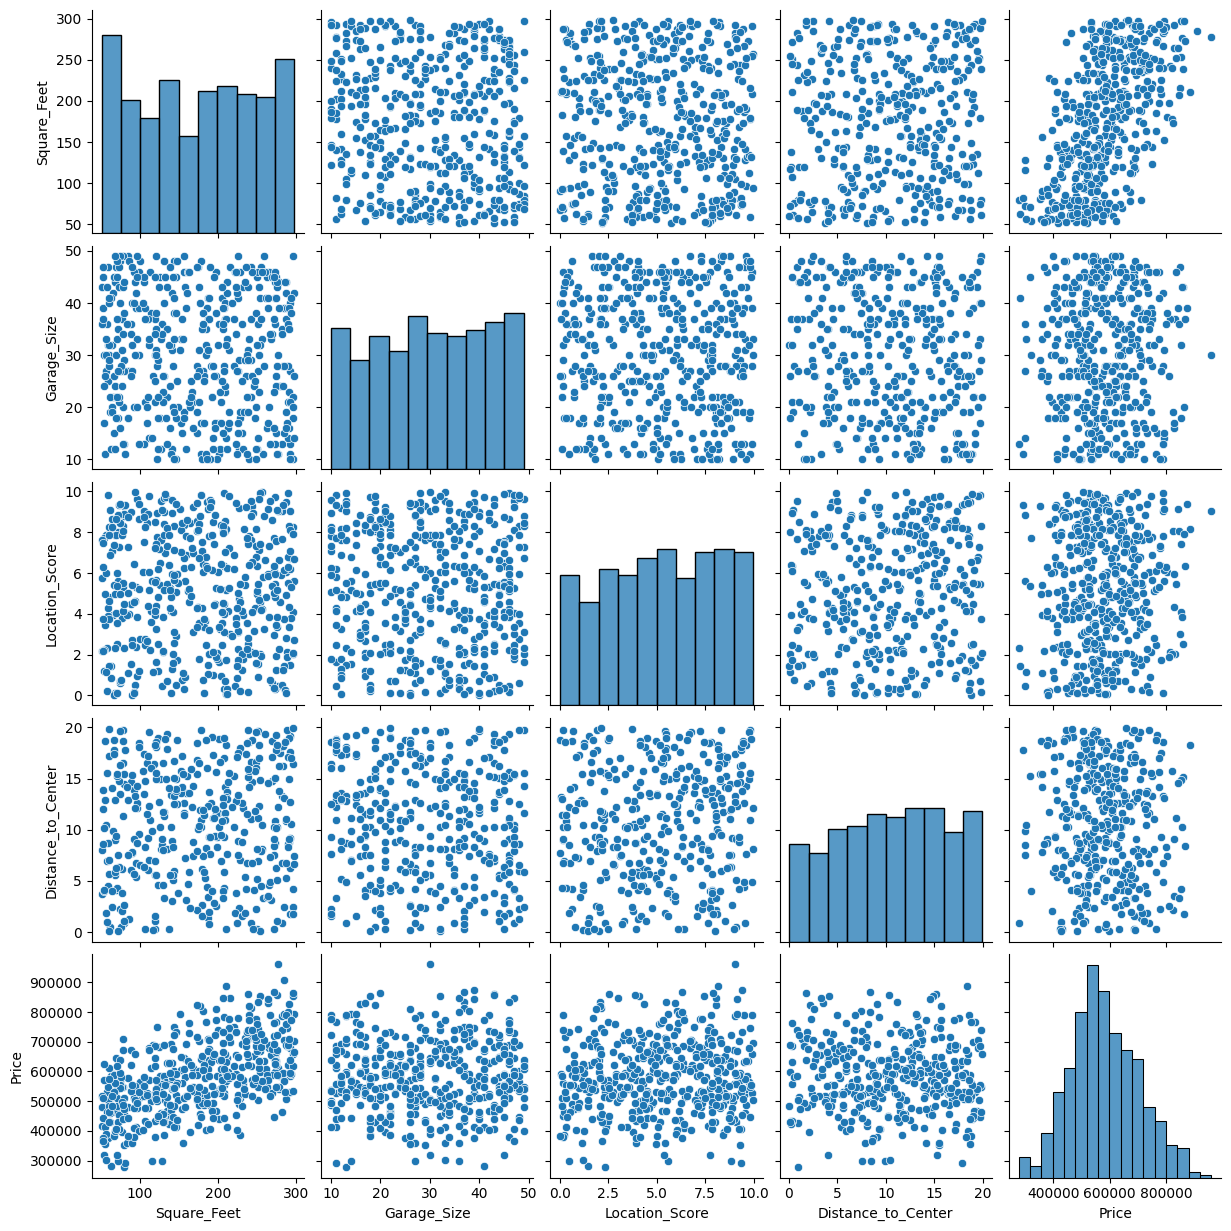

In [ ]:
df_plot = df.copy()
df_plot.drop(columns=['ID'], inplace=True)
sns.pairplot(df_plot)
plt.show()

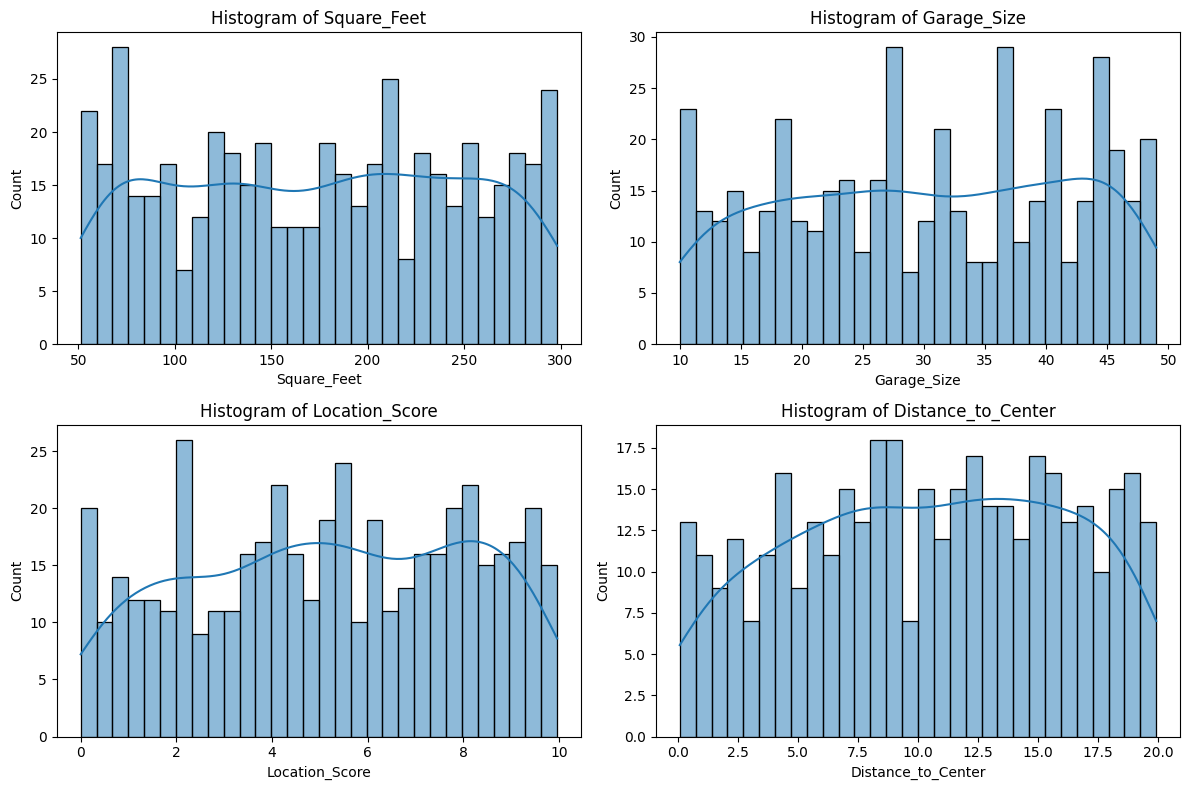

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols[:-1]):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

In [ ]:
df[num_cols].describe()

,Square_Feet,Garage_Size,Location_Score,Distance_to_Center,Price
count,486.000000,463.000000,472.000000,396.000000,482.000000
mean,174.378454,30.185745,5.198274,10.451424,582905.171008
std,74.735332,11.645933,2.866391,5.601969,123378.609003
min,51.265396,10.000000,0.004428,0.062818,276892.470100
25%,110.475759,20.000000,2.760650,5.904564,503205.143400
50%,177.929432,30.000000,5.272489,10.712509,576637.411800
75%,239.318092,40.500000,7.810841,15.179650,667431.212275
max,298.241199,49.000000,9.962623,19.927966,960678.274300


In [ ]:
# dữ liệu được scaling bằng minmax
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

df_scaled[num_cols].describe()

,Square_Feet,Garage_Size,Location_Score,Distance_to_Center,Price
count,486.000000,463.000000,472.000000,396.000000,482.000000
mean,0.498482,0.517583,0.521565,0.522956,0.447527
std,0.302602,0.298614,0.287842,0.282000,0.180435
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.239742,0.256410,0.276779,0.294070,0.330970
50%,0.512860,0.512821,0.529018,0.536099,0.438361
75%,0.761422,0.782051,0.783919,0.760973,0.571142
max,1.000000,1.000000,1.000000,1.000000,1.000000


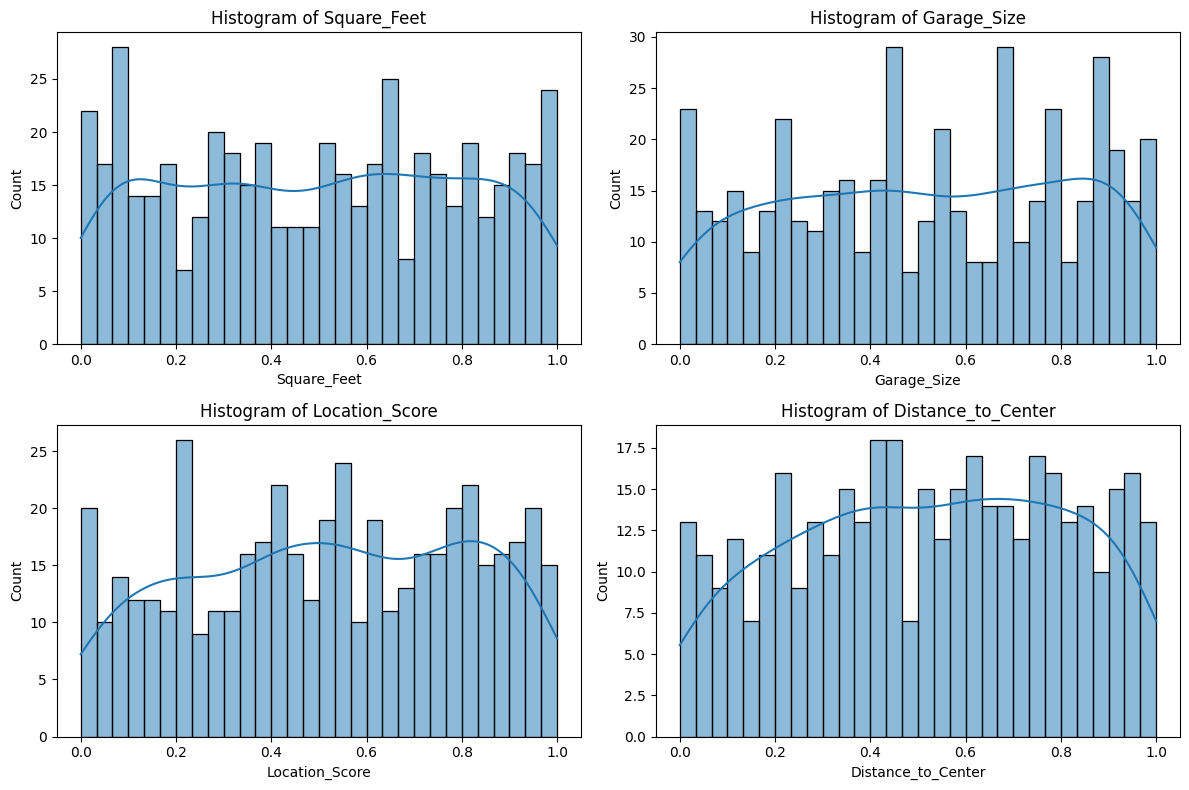

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols[:-1]):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_scaled[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

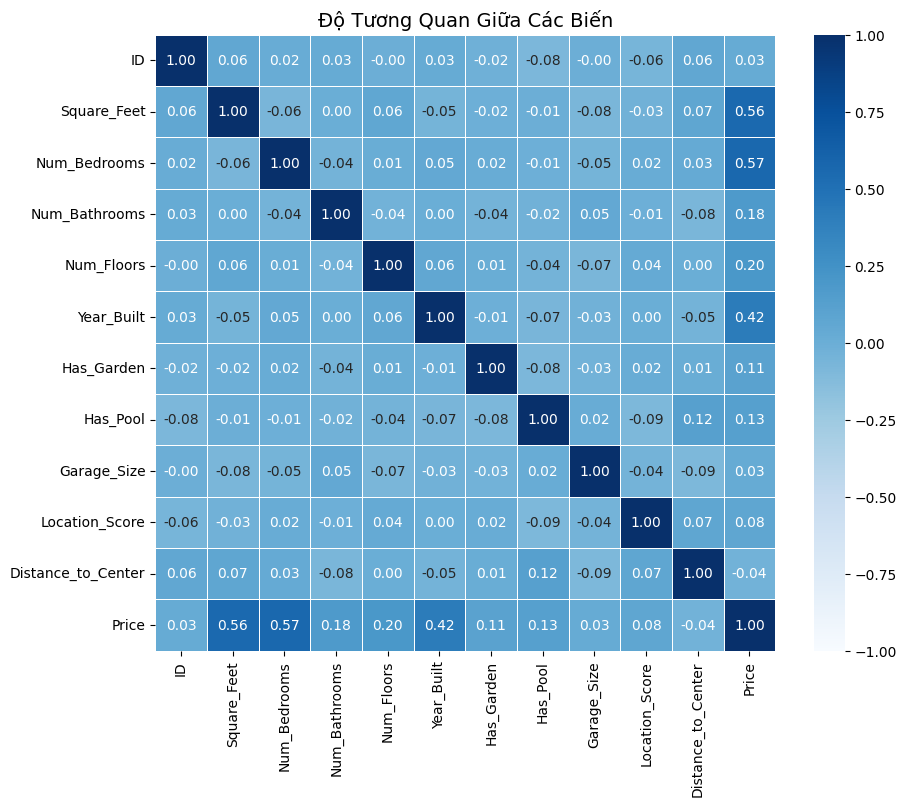

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Độ Tương Quan Giữa Các Biến", fontsize=14)
plt.show()

# 2. Xử lý dữ liệu

In [ ]:
df.drop(columns=['ID'], inplace=True)
# df.dropna(subset=['Price'], inplace=True)
cols = df.columns.tolist()
df.shape

(500, 11)

In [ ]:
df.duplicated().sum()

0

## a. Xóa dữ liệu thiếu

### Xóa hàng

In [ ]:
df_a = df.dropna()
print(df_a.isnull().sum())
print(df_a.shape)

Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64
(307, 11)


## b. Điền giá trị mean/median và mode

In [ ]:
df_b = df.copy()

df_b[num_cols] = df_b[num_cols].fillna(df_b[num_cols].mean())
df_b[cat_cols] = df_b[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))
print(df_b.isnull().sum())
print(df_b.shape)

Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64
(500, 11)


## c. Kỹ thuật nâng cao (KNN Imputation, MICE,...)

In [ ]:
df_c1 = df.copy()
df_c2 = df.copy()

#Sử dụng KNN Imputer
knn_imputer = KNNImputer(n_neighbors=10)
df_c1 = pd.DataFrame(knn_imputer.fit_transform(df_c1), columns=df.columns)

#Sử dụng MICE (IterativeImputer)
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df_c2 = pd.DataFrame(mice_imputer.fit_transform(df_c2), columns=df.columns)

print(df_c1.isnull().sum())
print("=" * 25)
print(df_c2.isnull().sum())

Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# 3. Chuẩn bị dữ liệu và xây dựng mô hình

In [ ]:
def model(df, method):
    x = df.drop(columns=['Price'])
    y = df['Price']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    ridge = Ridge(alpha=1.0)
    ridge.fit(x_train, y_train)
    ridge_pred = ridge.predict(x_test)

    lasso = Lasso(alpha=0.01)
    lasso.fit(x_train, y_train)
    lasso_pred = lasso.predict(x_test)

    results = {}
    for name, pred in {"Ridge": ridge_pred, "Lasso": lasso_pred}.items():
        mae = mean_absolute_error(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, pred)
        results[name] = [mae, mse, rmse, r2]

    return method, results

# 4. Kết quả

Detailed Results Table:
       Method      Model        MAE            MSE       RMSE   R2 Score
   delete_row      Ridge   16642.52   420449212.69   20504.86     0.9726
   delete_row      Lasso   15047.67    348119568.2   18657.96     0.9773
   ========== ========== ==========     ========== ========== ==========
mean_and_mode      Ridge   34515.73  2465672476.39   49655.54     0.8348
mean_and_mode      Lasso   33844.42  2420865642.47   49202.29     0.8378
   ========== ========== ==========     ========== ========== ==========
          knn      Ridge   21259.26  1037328703.06   32207.59      0.932
          knn      Lasso   20902.34  1005611288.29   31711.37     0.9341
   ========== ========== ==========     ========== ========== ==========
         mice      Ridge   15437.51   384250313.26    19602.3     0.9747
         mice      Lasso   14642.86   345225891.47   18580.26     0.9773


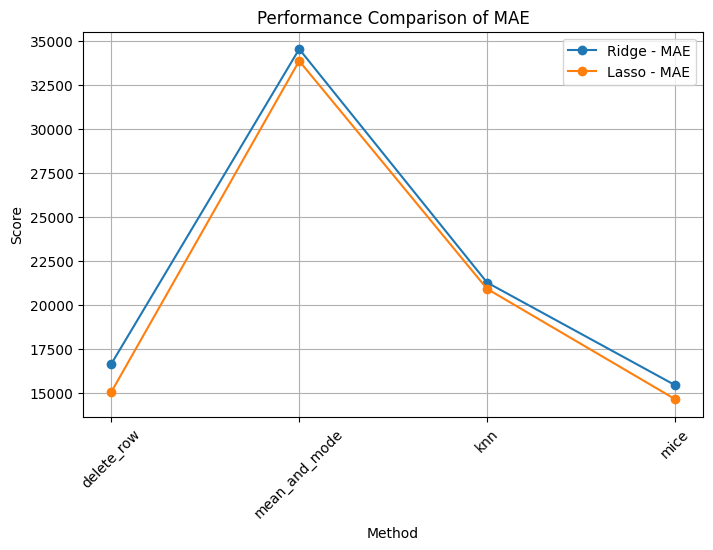

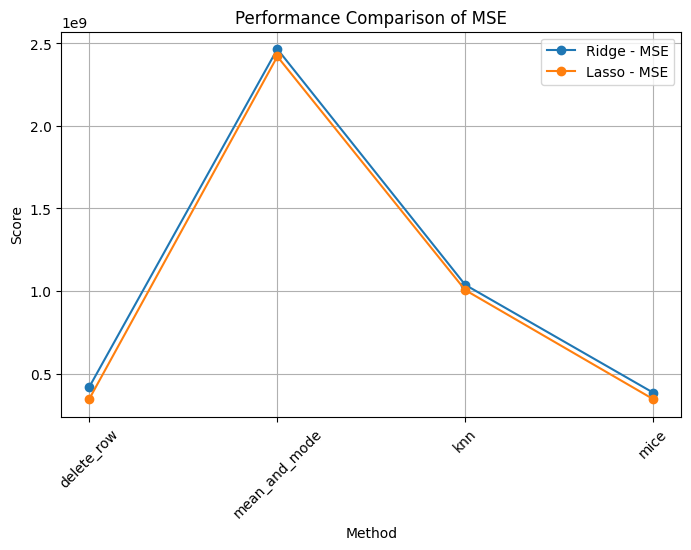

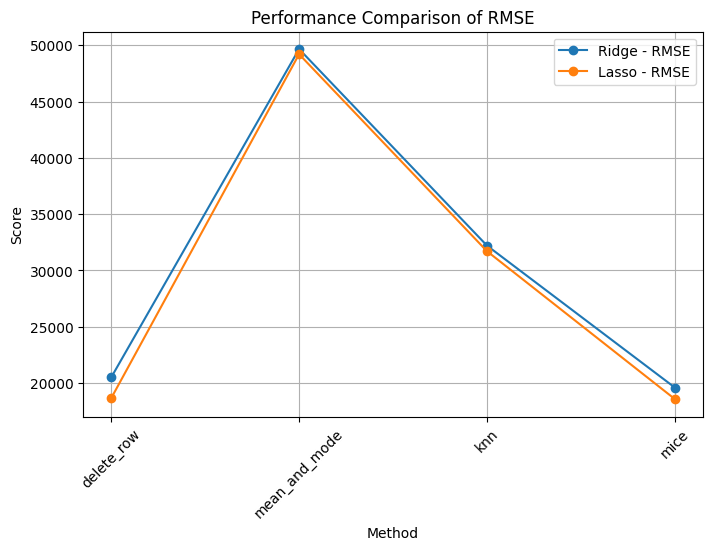

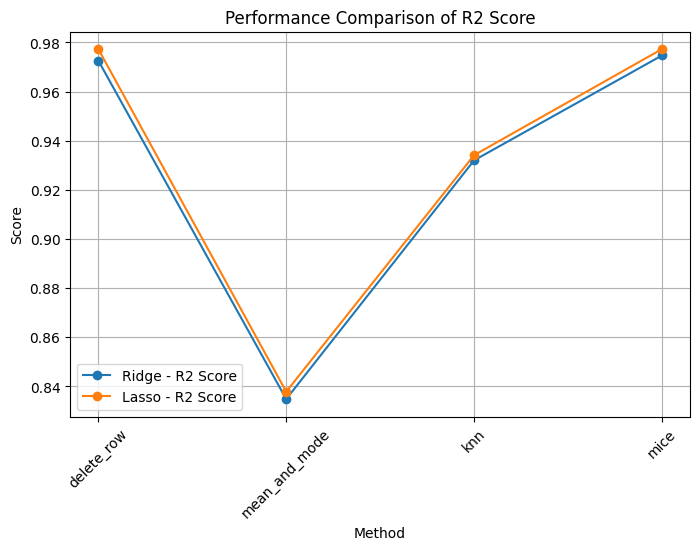

In [ ]:
df_arr = [df_a, df_b, df_c1, df_c2]
df_n = ['delete_row', 'mean_and_mode', 'knn', 'mice']

overall_results = {}

for i in range(len(df_arr)):
    method, res = model(df_arr[i], df_n[i])
    overall_results[method] = res

data = []
for method, models in overall_results.items():
    for model_name, metrics in models.items():
        data.append([method, model_name] + metrics)

columns = ['Method', 'Model', 'MAE', 'MSE', 'RMSE', 'R2 Score']
df_results = pd.DataFrame(data, columns=columns)

df_results[['MAE', 'MSE', 'RMSE']] = df_results[['MAE', 'MSE', 'RMSE']].round(2)
df_results[['R2 Score']] = df_results[['R2 Score']].round(4)

# Hiển thị kết quả
print("Detailed Results Table:")

output_rows = []
last_method = None

for _, row in df_results.iterrows():
    if last_method is not None and row["Method"] != last_method:
        output_rows.append(["="*10] * len(df_results.columns))
    output_rows.append(row.values)
    last_method = row["Method"]

df_display = pd.DataFrame(output_rows, columns=df_results.columns)
print(df_display.to_string(index=False))

metrics = ['MAE', 'MSE', 'RMSE', 'R2 Score']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in df_results['Model'].unique():
        subset = df_results[df_results['Model'] == model]
        plt.plot(subset['Method'], subset[metric], marker='o', linestyle='-', label=f'{model} - {metric}')

    plt.xlabel('Method')
    plt.ylabel('Score')
    plt.title(f'Performance Comparison of {metric}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
